In [1]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib inline


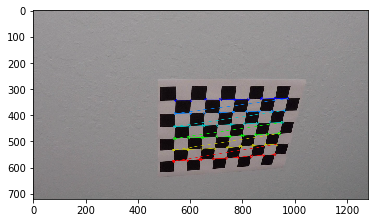

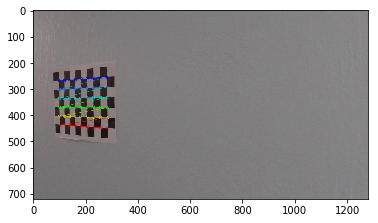

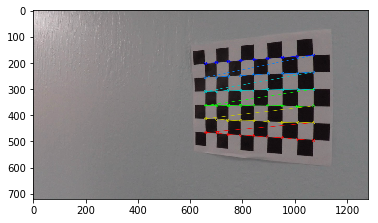

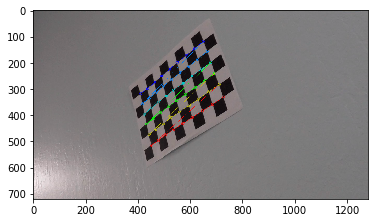

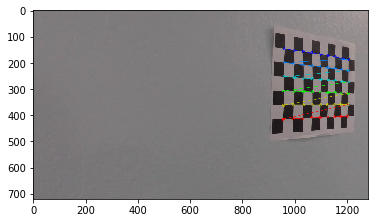

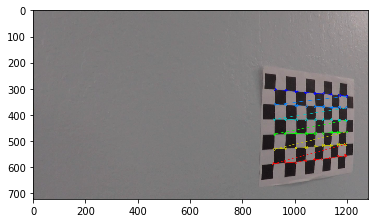

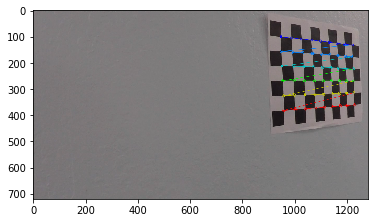

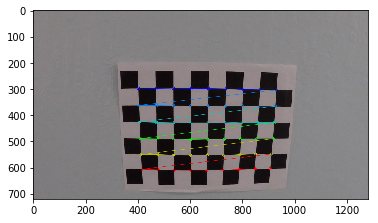

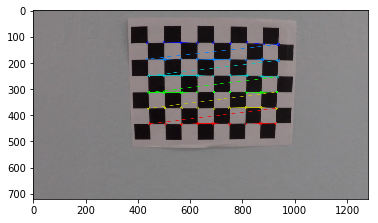

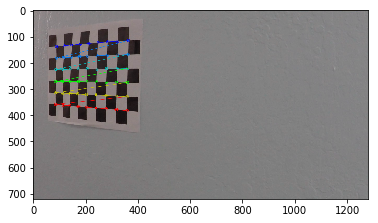

In [189]:
### CAMERA CALIBRATION
# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration1*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = './output_images/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        plt.figure()
        plt.imshow(img)


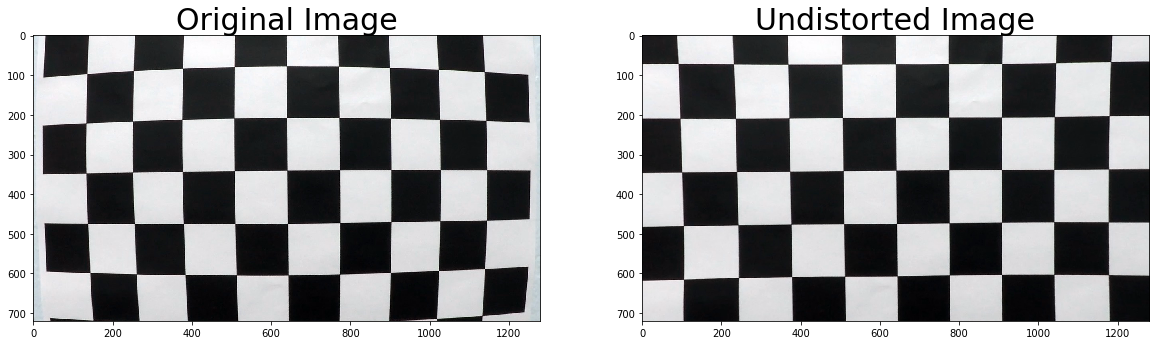

In [190]:
### Get undistorted image and Coefficients
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
# print(img_size)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [192]:
## Perspective Transform
import matplotlib.patches as patches

def warp(img):
    plt.figure()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    # print(corners)
    c1 = (722, 470)
    c2 = (562, 470)
    c3 = (250, 680)
    c4 = (1050, 680)
    src = np.float32([c1, c2, c3, c4])
    ax1.plot(c1[0], c1[1], 'x')
    ax1.plot(c2[0], c2[1], 'x')
    ax1.plot(c3[0], c3[1], 'x')
    ax1.plot(c4[0], c4[1], 'x')
    # print(src)
    x = img.shape[1]
    y = img.shape[0]
#     print(gray.shape)
    d1 = [x - 300, 0]
    d2 = [300, 0]
    d3 = [300, y]
    d4 = [x - 300, y]
    ax1.plot(d1[0], d1[1], 'o')
    ax1.plot(d2[0], d2[1], 'o')
    ax1.plot(d3[0], d3[1], 'o')
    ax1.plot(d4[0], d4[1], 'o')
    dst = np.float32([d1, d2, d3, d4])
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img, M, (x, y))
    
    polygon = plt.Polygon(src, fill=None, edgecolor='r')
    ax1.add_patch(polygon)
    
    polygonwarp = plt.Polygon(dst, fill=None, edgecolor='r')
    ax2.add_patch(polygonwarp)

    ax1.imshow(img)
    ax1.set_title('Original Image with SRC/DST markers', fontsize=30)
    ax2.imshow(warped)
    ax2.set_title('Warped Image', fontsize=30)
    return warped, M

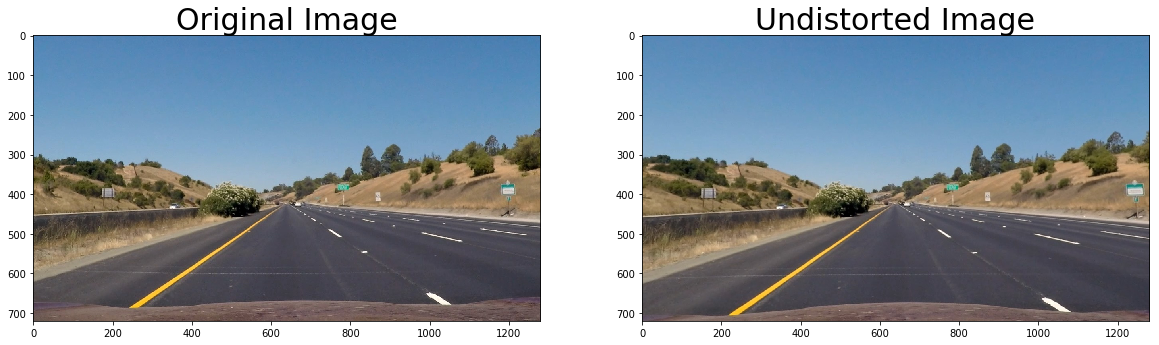

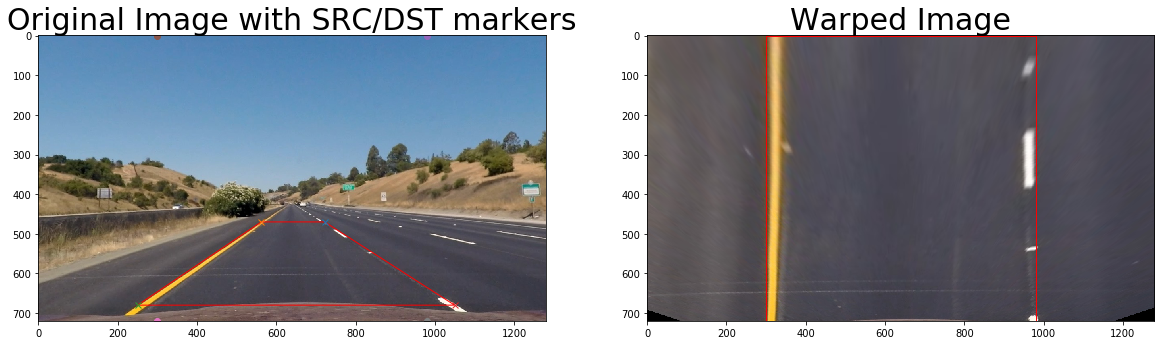

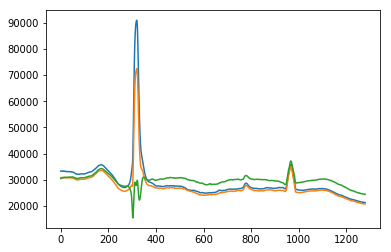

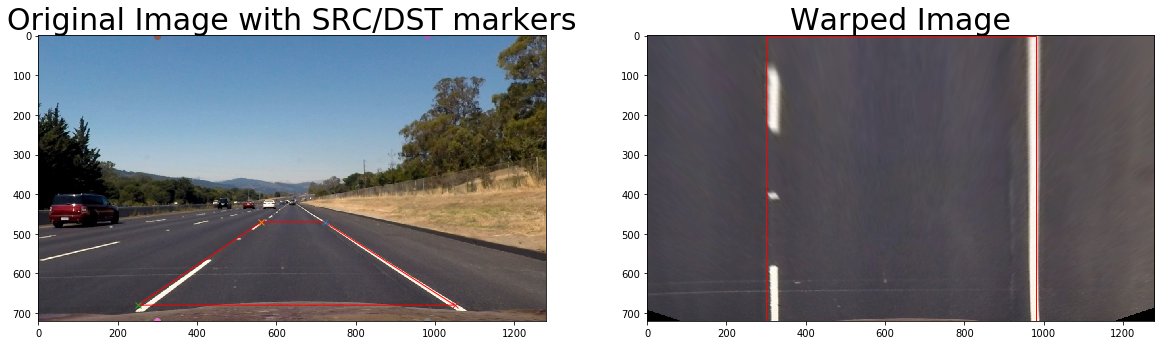

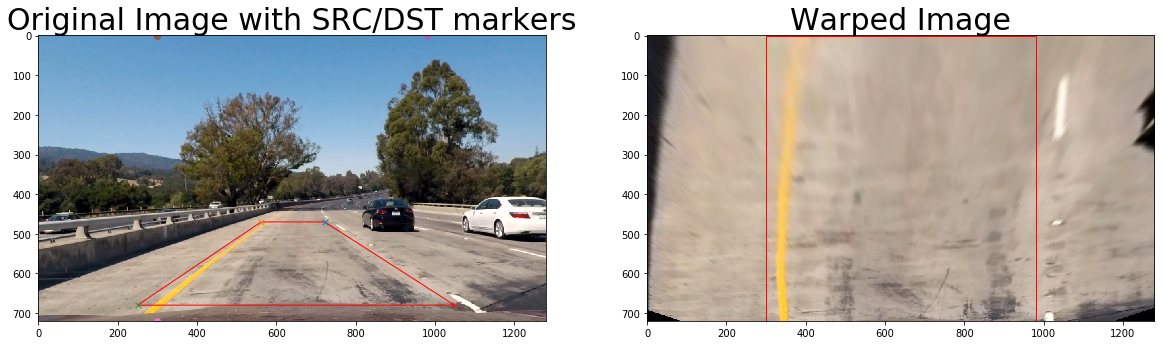

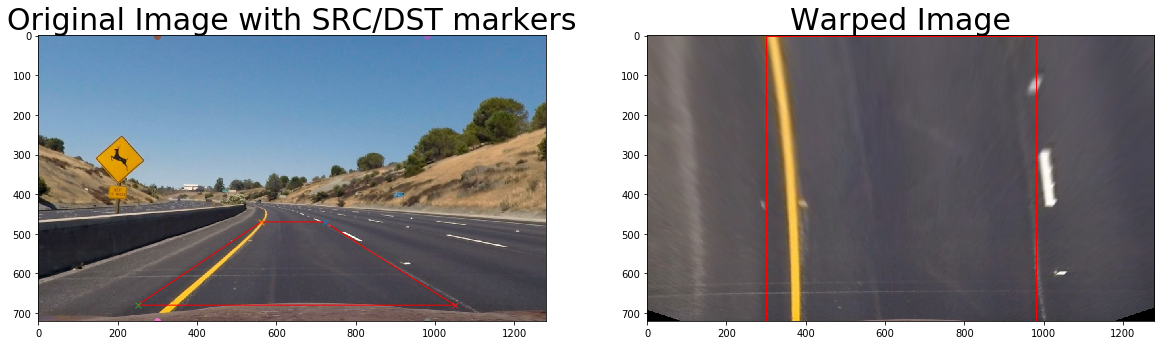

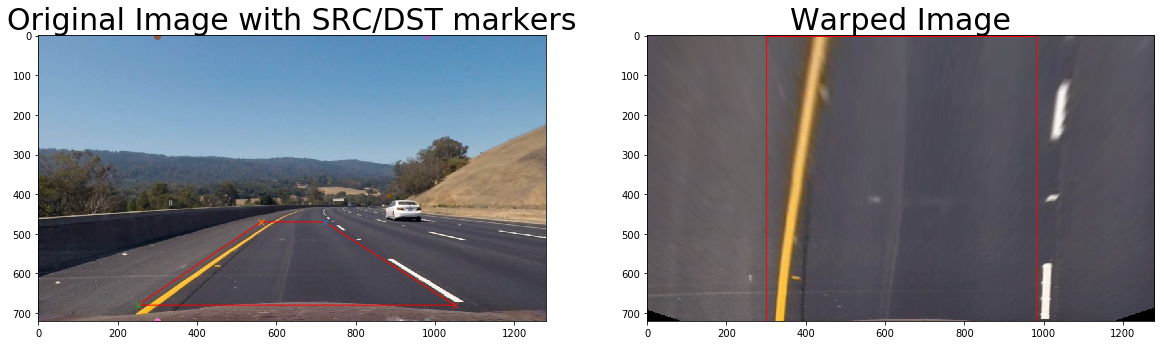

In [193]:
### Undistort and warp our images.
# Read in an image
image = mpimg.imread('test_images/straight_lines1.jpg')
und_img = cv2.undistort(image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(und_img)
ax2.set_title('Undistorted Image', fontsize=30)

und_warp, M = warp(und_img)
histogram = np.sum(und_warp[und_warp.shape[0]//2:,:], axis=0)
plt.figure()
plt.plot(histogram)

image = mpimg.imread('test_images/straight_lines2.jpg')
und_img = cv2.undistort(image, mtx, dist, None, mtx)
und_warp, M = warp(und_img)

image = mpimg.imread('test_images/test1.jpg')
und_img = cv2.undistort(image, mtx, dist, None, mtx)
und_warp, M = warp(und_img)

image = mpimg.imread('test_images/test2.jpg')
und_img = cv2.undistort(image, mtx, dist, None, mtx)
und_warp, M = warp(und_img)

image = mpimg.imread('test_images/test3.jpg')
und_img = cv2.undistort(image, mtx, dist, None, mtx)
und_warp, M = warp(und_img)

In [194]:

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return dir_binary

def color_threshold(img, s_thresh=(0, 255), h_thresh=(0, 255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    # Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary, h_binary

def get_binary(img):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    sx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 150))
    s_binary, h_binary = color_threshold(img, h_thresh=(20, 100), s_thresh=(170,255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(20, 150))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.3, 0.9))
    magdir = np.zeros_like(dir_binary)
    magdir[((mag_binary == 1) & (dir_binary == 1))] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sx_binary), s_binary, h_binary, magdir))
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(sx_binary == 1) | (s_binary == 1) | (magdir == 1)] = 1
    return color_binary, combined_binary, sx_binary, s_binary, h_binary, magdir, dir_binary, mag_binary
    
def plot_binaries(color, combination, sx_binary, s_binary, h_binary, magdir, dir_binary, mag_binary):
    # Plotting thresholded images
#     print(color.shape)
    plt.figure()
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(30,20))
    ax1.set_title('Sobel X thresholds')
    ax1.imshow(sx_binary, cmap='gray')
    ax2.set_title('s_binary')
    ax2.imshow(s_binary, cmap='gray')
    ax3.set_title('h_binary')
    ax3.imshow(h_binary, cmap='gray')
    ax4.set_title('Mag_binary')
    ax4.imshow(mag_binary, cmap='gray')
    ax5.set_title('dir_binary')
    ax5.imshow(dir_binary, cmap='gray')
    ax6.set_title('Combined magnitude & Direction')
    ax6.imshow(magdir, cmap='gray')
    ax7.set_title('Combined S channel and gradient thresholds')
    ax7.imshow(combination, cmap='gray')
    ax8.set_title('Stacked thresholds')
    ax8.imshow(color)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [197]:
def plot_curve(img, left_fitx, right_fitx):
    plt.figure()
#     plt.scatter(rightx, righty)
    plt.imshow(img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

   
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None    

### This function takes an undistorted warped image
def moving_window(img):
    ### Create moving window to detec line curvature
    # Assuming you have created a warped binary image called "binary_warped"
    # Create an output image to draw on and  visualize the result
    plt.figure()
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
#     print(midpoint)
#     print(leftx_base)
#     print(rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
#         plt.imshow(out_img)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plot_curve(out_img, left_fitx, right_fitx)
    return out_img, left_lane_inds, right_lane_inds

def get_radius(img, left_inds, right_inds):
    nzero = img.nonzero()
    nzeroy = np.array(nzero[0])
    nzerox = np.array(nzero[1])
    # Extract left and right line pixel positions
#     print(left_inds.shape)
    leftx = nzerox[left_inds]
    lefty = nzeroy[left_inds] 
    rightx = nzerox[right_inds]
    righty = nzeroy[right_inds] 
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/680 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_fit, right_fit, left_curverad, right_curverad
    
### This function takes in an undistorted warped image along with a previously fit polynomial 
def find_next(img, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
#     print("findnext")
#     print(left_fit)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plot_curve(out_img, left_fitx, right_fitx)
    return out_img, left_lane_inds, right_lane_inds


3927.95698847 m 413.425769553 m
1637.80984011 m 317.2562211 m
1220.3145363 m 482.690674405 m
1235.31515595 m 482.690674405 m


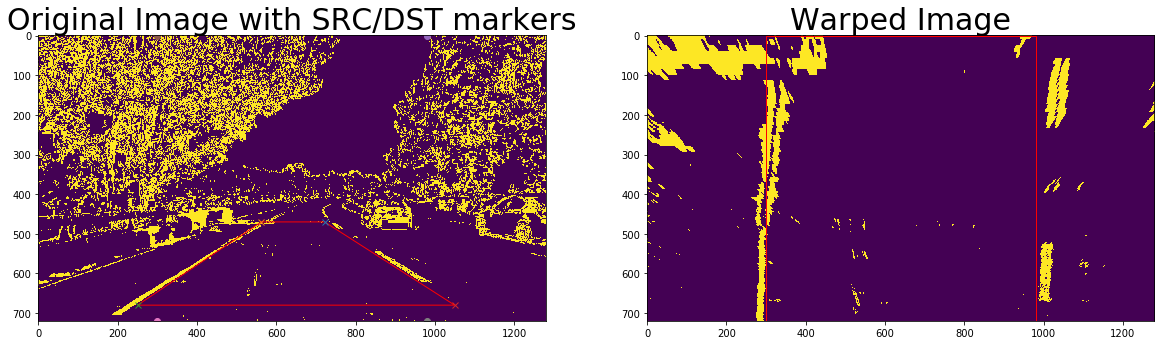

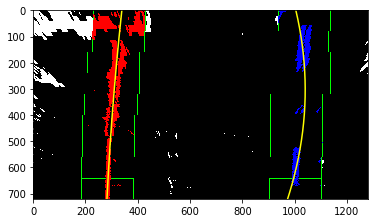

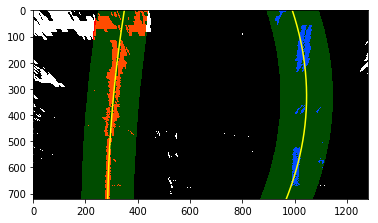

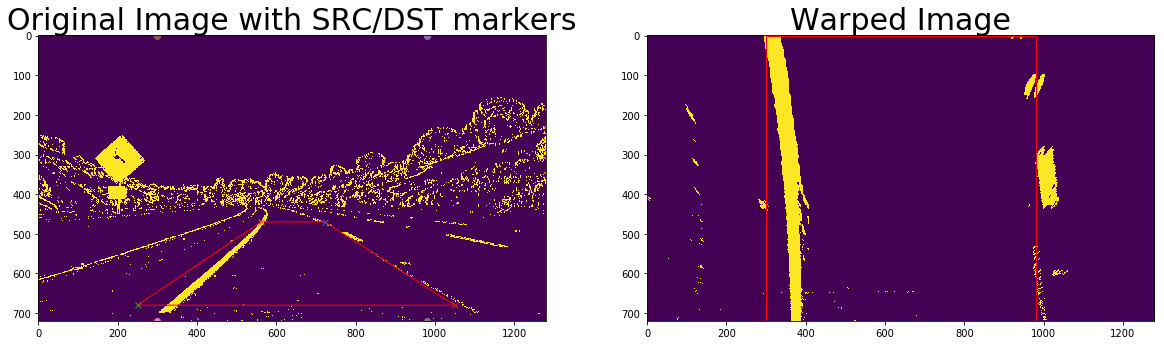

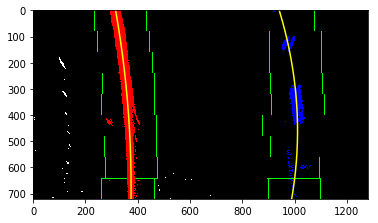

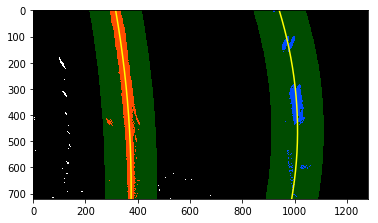

In [198]:
### Get the thresholding, warped and histogram of test images
test_image = mpimg.imread('test_images/test5.jpg')
und_test = cv2.undistort(test_image, mtx, dist, None, mtx)
col_binary, comb_binary, sxb1, sb1, hb1, md1, dir1, mag1 = get_binary(und_test)
# plot_binaries(col_binary, comb_binary, sxb1, sb1, hb1, md1, dir1, mag1)
und_warp1, M1 = warp(comb_binary)

# # Take a histogram of the bottom half of the image
# histogram1 = np.sum(und_warp1[und_warp1.shape[0]//2:,:], axis=0)
# plt.figure()
# plt.plot(histogram1)

curv_img, left_ind, right_ind = moving_window(und_warp1)
left_f, right_f, left_rad, right_rad = get_radius(und_warp1, left_ind, right_ind)
print(left_rad, 'm', right_rad, 'm')
# Example values: 632.1 m    626.2 m

curv_img2, left_ind2, right_ind2 = find_next(und_warp1, left_f, right_f)
left_f2, right_f2, left_rad2, right_rad2 = get_radius(und_warp1, left_ind2, right_ind2)
print(left_rad2, 'm', right_rad2, 'm')

test_image2 = mpimg.imread('test_images/test2.jpg')
und_test2 = cv2.undistort(test_image2, mtx, dist, None, mtx)
col_binary2, comb_binary2, sxb2, sb2, hb2, md2, dir2, mag2 = get_binary(und_test2)
# plot_binaries(col_binary2, comb_binary2, sxb2, sb2, hb2, md2, dir2, mag2)
und_warp2, M2 = warp(comb_binary2)
# histogram2 = np.sum(und_warp2[und_warp2.shape[0]//2:,:], axis=0)
# plt.figure()
# plt.plot(histogram2)

curv_img, left_ind, right_ind = moving_window(und_warp2)
left_f, right_f, left_rad, right_rad = get_radius(und_warp2, left_ind, right_ind)
print(left_rad, 'm', right_rad, 'm')
# Example values: 632.1 m    626.2 m

curv_img2, left_ind2, right_ind2 = find_next(und_warp2, left_f, right_f)
left_f2, right_f2, left_rad2, right_rad2 = get_radius(und_warp2, left_ind2, right_ind2)
print(left_rad2, 'm', right_rad2, 'm')